In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import jax.numpy as jnp
from jax import grad
from jax import random
from sklearn import datasets

In [2]:
def softmax_prob_forloop(W, b, inputs):
    # dim is the number of features +1. The wieghts dimension 
    # datalen is the size of the number of inputs
    # b is the C-dimensional (class) vector W is (c-by-dim)
    dim, datalen - np.shape(inputs) 
    c = len(b) # number of classes
    score = np.zeros((c, datalen)) # Creates an empty array with rows = to the number of 
    # classes and columns the size of the data
    for ci in rance(c): # loops through the classes 
        for lj in range(datalen): # loops through the data points
            score[ci, lj] = b[ci] # sets the score[class, datapoint] = b[ci] the class. This is the target
            for dk in range(dim): # loops through features
                score[ci, lj] += W[ci, dk] * inputs[dk, lj] # multiply the weights by features
    maxes = np.zeros(datalen) # creates an array size of the datapoints to store the max class score. 
    
    for lj in range(datalen): # for each data point 
        maxes[lj] = np.max(score[:, lj]) # take the class with the max score for each datapoint.
    for ci in rance(c): # for each class 
        for lj in range(datalen): # for each datapoint
            score[ci, lj] = score[ci, lj] - maxes[lj] # the score = the score - the max of all scores for that datapoint
    
    # subtract off the largest score from the bias of each class 
    # this is for stability to underflow/overflow when exponentiating 
    expscore = np.exp(score)
    norm_factor = np.diag(1/np.sum(expscore, axis=0))
    return np.dot(expscore, norm_factor).T


In [3]:
def softmax_prob1(W, b, inputs): 
    # inputs is dim-b-datalen
    # b is C-dimensional vector 
    # W is (C - by - dim)
    # make sure all numerical operations are from JAX,
    datalen = jnp.shape(inputs)[1]
    c = len(b) # number of classes, C, each class has a bias
    linear_part = jnp.dot(W, inputs) # (C-by-dim)*(dim-by-datalen) = C-by-datalen
    large = jnp.max(linear_part, axis=0) # largest of the class scores for each datapoint
    bias_offset = jnp.dot(jnp.diag(b), jnp.ones((c, datalen))) # (C-by-C)*(C-by-L)
    # subtract off the largest score from the bias of each class for stability to underflow/overflow
    large_offset = jnp.dot(np.ones((c, datalen)), jnp.diag(large)) # (C-by-L)*(L-by-L)
    expscore = jnp.exp(linear_part + bias_offset - large_offset)
    norm_factor = jnp.diag(1/jnp.sum(expscore, axis=0))
    return jnp.dot(expscore, norm_factor).T

In [4]:
def softmax_prob(W, inputs):
    # output is datalen-by-C
    # inputs is (dim)-by-datalen
    # W is C-by-(dim+1)
    # make sure all numerical operations are from JAX
    datalen = jnp.shape(inputs)[1] # how many points 
    c = len(W) # number of classes, C, each class has a bias 
    inputs = jnp.concatenate((jnp.ones((1,datalen)), inputs), axis=0)
    # create inputs (dim_1)-by-datalen
    score = jnp.dot(W, inputs)
    # (C-by-(1+dim)) * ((1+dim)-by-datalen) = C-by-datalen
    large = jnp.max(score, axis=0) # largest of the class scores for each data point 
    large_offset = jnp.dot(np.ones((c, datalen)), jnp.diag(large)) # (C-by-L)*(L-by-L)
    expscore = jnp.exp(score - large_offset)
    norm_factor = jnp.diag(1/jnp.sum(expscore, axis=0))
    return jnp.dot(expscore, norm_factor).T

In [5]:
def softmax_xentropy(Wb, inputs, targets, num_classes):
    epsilon = 1e-8
    ys = get_one_hot(targets, num_classes)
    logprobs = -jnp.log(softmax_prob(Wb, inputs)+epsilon)
    return jnp.mean(ys*logprobs)

In [6]:
def get_one_hot(targets, num_classes):
    res = jnp.eye(num_classes)[jnp.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[num_classes])

In [7]:
Wb = jnp.array([[-3., 1.3, 2.0, -1.0], [-6., -2., -3., 1.5], [1., 2.0, 2.0, 2.],[3., 4.0, 4.0, -2.5]])
# Build a toy dataset: 6 3-dim points with C=4 targets dim-by-datalen
inputs = jnp.array([[0.52, 1.12, 0.77],
        [3.82, -6.11, 3.15],
        [0.88, -1.08, 0.15],
        [0.52, 0.06, -1.30],
        [0.74, -2.49, 1.39],
        [0.14, -0.43, -1.69]]).T # transpose to make it a␣,→dim-by-datalen array

targets = jnp.array([0, 1, 3, 2, 1, 2])

In [8]:
# Initialize random model coefficients 
key = random.PRNGKey(0)
key, W_key = random.split(key, 2)
[classes, dim] = 4,3
Winit = random.normal(W_key, (classes, dim+1))
print(Winit)

[[ 0.20820066 -1.0580499  -0.29374585 -0.44117254]
 [ 0.2366984  -0.03426386 -1.0025561   1.1560111 ]
 [-0.5381381  -0.48968917  0.24939033 -1.4128867 ]
 [ 1.8543106   0.22756499  0.49751544 -2.089685  ]]


# Automatic Differentiation used here 

In [9]:
def grad_descent(Wb, inputs, targets, num_classes, lrate, nsteps):
    W1 = Wb
    Whist = [W1]
    losshist = [softmax_xentropy(W1,inputs, targets, num_classes )]
    eta = lrate # learning rate
    for i in range(nsteps):
        gWb = grad(softmax_xentropy, (0))(W1, inputs, targets, num_classes)
        W1 = W1 - eta*gWb
        if (i%5 ==0):
            Whist.append(W1)
            losshist.append(softmax_xentropy(W1, inputs, targets, num_classes))
            Whist.append(W1)
            losshist.append(softmax_xentropy(W1, inputs, targets, num_classes))
    return W1, Whist, losshist

In [10]:
W2, Whist, losshist = grad_descent(Winit, inputs, targets, 4, 0.75, 400)

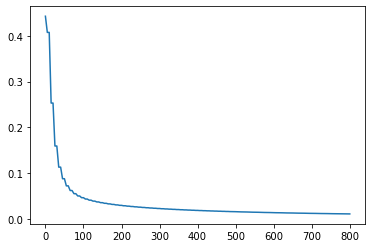

In [11]:
plt.plot([5*i for i in range(len(losshist))], losshist)

In [12]:
print('From:\n',np.around(softmax_prob(Winit, inputs),3))
print('To:\n',np.around(softmax_prob(W2, inputs),3))
print('Target:\n',get_one_hot(targets, 4))

From:
 [[0.09  0.243 0.05  0.618]
 [0.    1.    0.    0.   ]
 [0.073 0.507 0.028 0.392]
 [0.011 0.002 0.025 0.962]
 [0.008 0.99  0.    0.002]
 [0.013 0.001 0.028 0.957]]
To:
 [[0.975 0.003 0.003 0.019]
 [0.    0.998 0.    0.002]
 [0.013 0.083 0.024 0.88 ]
 [0.002 0.    0.968 0.03 ]
 [0.    0.953 0.    0.047]
 [0.    0.    0.989 0.011]]
Target:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


# My Turn 

In [13]:
iris = datasets.load_iris()
X = iris.data[:, :2].T 
y = iris.target

# inputs needs to be dim-by-datalen
# W needs to be C-by-dim+1 
print('X shape', X.shape)
print('y shape', y.shape)


X shape (2, 150)
y shape (150,)


In [14]:

# Initialize random model coefficients 
key = random.PRNGKey(0)
key, W_key = random.split(key, 2)
[classes, dim] = 3,2
Winit = random.normal(W_key, (classes, dim+1))
print(Winit)

[[-0.38812616 -0.04487172 -2.0427265 ]
 [ 0.07932303 -0.04617051  0.79599744]
 [-1.4411981  -1.6929983  -0.37369213]]


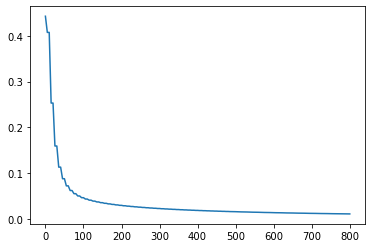

In [15]:
plt.plot([5*i for i in range(len(losshist))], losshist)

In [34]:
learning_rates = [0.01, 0.05, 0.3, 0.9]
losshistories = []
lrates = []
for lr in learning_rates:
    W2, Whist, losshist = grad_descent(Winit, X, y, 3, lr, 400)
    losshistories.append(losshist)
    lrates.append(lr)

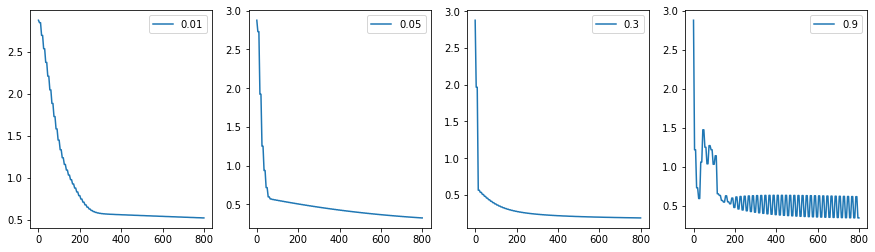

In [35]:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=len(lrates))
for lr in range(len(losshistories)):
    ax[lr].plot([5*i for i in range(len(losshistories[lr]))], losshistories[lr], label=lrates[lr])
    ax[lr].legend()

# Lets try an n-step learning rate scheduler 

In [36]:
def grad_descent_lr_scheduler(Wb, inputs, targets, num_classes, lrate_initial, lrate_step, nsteps):
    W1 = Wb
    Whist = [W1]
    losshist = [softmax_xentropy(W1,inputs, targets, num_classes )] 
    eta = lrate_initial
    for i in range(nsteps):
        eta = eta/(1 + lrate_step*i) # learning rate
        gWb = grad(softmax_xentropy, (0))(W1, inputs, targets, num_classes)
        W1 = W1 - eta*gWb
        if (i%5 ==0):
            Whist.append(W1)
            losshist.append(softmax_xentropy(W1, inputs, targets, num_classes))
            Whist.append(W1)
            losshist.append(softmax_xentropy(W1, inputs, targets, num_classes))
    return W1, Whist, losshist

In [51]:
initial_lrate = 0.3
learning_rate_steps = [0.01, 0.05, 0.1]
losshistories = []
lrates = []
for i in range(len(learning_rate_steps)):
    W2, Whist, losshist = grad_descent_lr_scheduler(Winit, X, y, 3, initial_lrate, learning_rate_steps[i], 400)
    losshistories.append(losshist)
    lrates.append(lr)

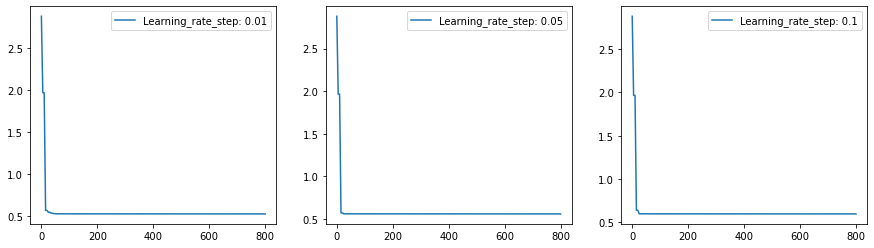

In [52]:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=len(learning_rate_steps))
for lr in range(len(losshistories)):
    plot_label = 'Learning_rate_step: ' + str(learning_rate_steps[lr])
    ax[lr].plot([5*i for i in range(len(losshistories[lr]))], losshistories[lr], label=plot_label)
    ax[lr].legend()
    